# Introduction

This work is based on the Kaggle project https://www.kaggle.com/shayanfazeli/heartbeat. The dataset in this work is composed of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. The number of samples in both collections is large enough for training a deep neural network.

This dataset has been used in exploring heartbeat classification using deep neural network architectures, and observing some of the capabilities of transfer learning on it. The signals correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. These signals are preprocessed and segmented, with each segment corresponding to a heartbeat

# Libraries

In [33]:
#Basics
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from ipywidgets import interact, fixed
import random
import warnings
import operator

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, label_ranking_loss, coverage_error, silhouette_score, confusion_matrix, classification_report, label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder

# Imbalanced learning
from imblearn.over_sampling import RandomOverSampler

# Deep Learning
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import backend as K

# Data and EDA

First we import the data and see its dimensionality

In [2]:
mitbih_train = pd.read_csv("data/mitbih_train.csv", header=None)
mitbih_test  = pd.read_csv("data/mitbih_test.csv", header=None)

print( "Shape of the train dataset", mitbih_train.shape )
print( "Shape of the test data set", mitbih_test.shape )

Shape of the train dataset (87554, 188)
Shape of the test data set (21892, 188)


and taking a look to the data

In [3]:
mitbih_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


we can see that the columns have generic names, but the last column is the label, so we rename and discretize it

In [4]:
mitbih_train.columns = [str(i) for i in range(187)] + ["label"]
mitbih_test.columns  = [str(i) for i in range(187)] + ["label"]

mitbih_train["label"] = mitbih_train["label"].apply(int)
mitbih_test["label"]  = mitbih_test["label"].apply(int)

mitbih_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Now we can start our analysis by looking at the signals of the diferent classes of patients

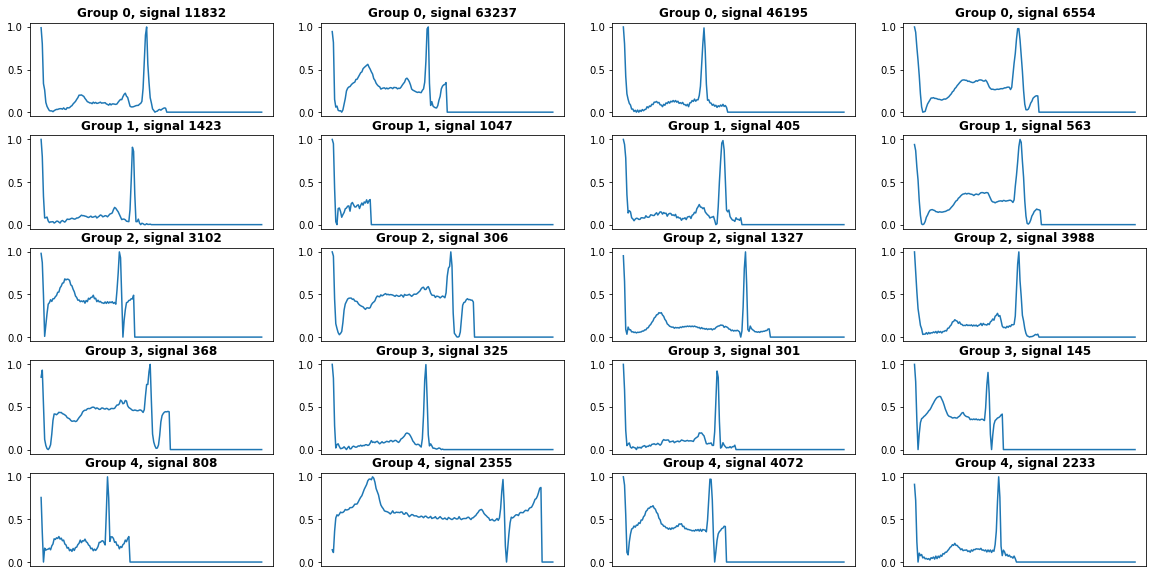

In [5]:
plt.figure(figsize = (20,10))
j = 1
for label in [0,1,2,3,4]:
    df = mitbih_train.drop("label", axis = 1)
    df_filtered = df[mitbih_train.label == label].reset_index(drop = True)
    size = 4
    signals = np.random.choice(df_filtered.index, size = size, replace = False)
    for signal in signals:
        plt.subplot(5, size, j)
        plt.plot(df.iloc[signal] ,label = "Example signal" )
        plt.title("Group {}, signal {}".format(label, signal), weight = "bold")
        plt.xticks([])
        j = j + 1
plt.show()

so we can see that a priori the signals in each class are very different between them, so we provide an interactive widget to easily select which signal is wanted to show

In [8]:
def show_plot(data, Signal):
    plt.plot(data.iloc[Signal] )
    plt.title("Group {}, signal {}".format(data.iloc[Signal,-1], Signal), weight = "bold")
    plt.xticks([])
    plt.show()

interact(lambda **kwargs: show_plot(mitbih_train, **kwargs), Signal = (0, mitbih_train.shape[0]))

interactive(children=(IntSlider(value=43777, description='Signal', max=87554), Output()), _dom_classes=('widge…

<function __main__.<lambda>(**kwargs)>

Another thing we can do is to look at the distribution of the classes

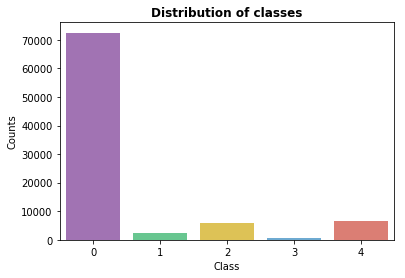

In [6]:
colors  = ["#A569BD", "#58D68D", "#F4D03F", "#5DADE2", "#EC7063"]
handles = [mpatches.Patch(color = colors[i], label = "{}".format(i)) for i in range(5)]

sns.countplot(x = "label", data = mitbih_train, palette = colors)
plt.title("Distribution of classes", weight = "bold")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

In [7]:
props = mitbih_train.groupby("label").count().iloc[:,0]
total = props.sum()

props/total

label
0    0.827729
1    0.025390
2    0.066108
3    0.007321
4    0.073452
Name: 0, dtype: float64

so we can see that the classes are unbalanced. This can point to an analysis the one vs. all, so, seeing this distribution

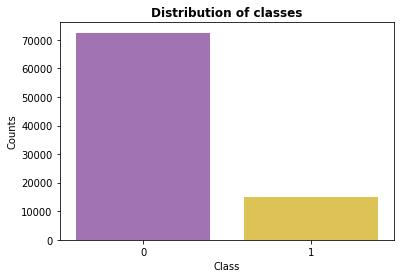

In [8]:
mitbih_train["label_ovr"] = mitbih_train.label.map({0:0, 1:1, 2:1, 3:1, 4:1})
colors2  = ["#A569BD", "#F4D03F"]
handles2 = [mpatches.Patch(color = colors2[i], label = "{}".format(i)) for i in range(2)]

sns.countplot(x = "label_ovr", data = mitbih_train, palette = colors2)
plt.title("Distribution of classes", weight = "bold")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

we can see that the unbalancing is smaller, but still notorious.

# Dimensonality reduction

## PCA

We can start by seeing which are the most significative directions of variance on the data and seeing the percentage of variance explained by these directions. This ca be done by performing a Principal Component Analysis

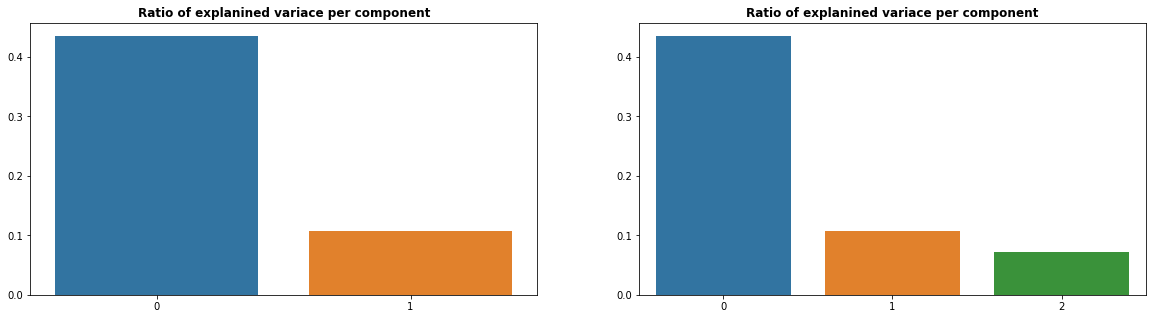

In [9]:
df_train = mitbih_train.drop(["label", "label_ovr"], axis = 1)
df_label = mitbih_train["label"]
df_label_ovr = mitbih_train["label_ovr"]

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
pca = PCA(n_components = 2)
pca.fit(df_train)
explained = pca.explained_variance_ratio_.tolist()
sns.barplot([0,1], explained)
plt.title("Ratio of explanined variace per component", weight = "bold")

plt.subplot(1,2,2)
pca = PCA(n_components = 3)
pca.fit(df_train)
explained = pca.explained_variance_ratio_.tolist()
sns.barplot([0,1,2], explained)
plt.title("Ratio of explanined variace per component", weight = "bold")
plt.show()

so we can see that the reduction is not so good, {{np.sum(explained[0:2])}} for 2 components and {{np.sum(explained[0:3])}} for 3 components, but it can still be useful to make a 2D representation of the signals

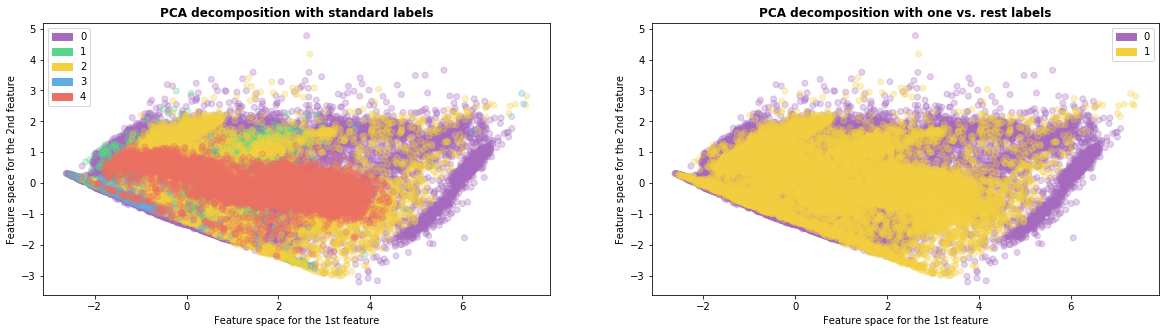

In [10]:
pca = PCA(n_components = 2)
df_train_transformed = pca.fit_transform(df_train)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label.map({i:colors[i] for i in range(5)}), 
            alpha = 0.3)
plt.title("PCA decomposition with standard labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles)
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_ovr.map({i:colors2[i] for i in range(2)}), 
            alpha = 0.3)
plt.title("PCA decomposition with one vs. rest labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles2)
plt.show()

seeing that efectively the decomposition is not useful.

## Manifold Learing

We can try now the approach of manifold learning

In [ ]:
def stratified_sample(data, column, frac):
    list_df = [data[data[column] == label].sample(frac=frac).reset_index(drop=True) for label in list(np.unique(data[column]))]
    return pd.concat(list_df)

df = stratified_sample(mitbih_train, "label", 0.2)
df_train_m = df.drop(["label", "label_ovr"], axis = 1)
df_label_m = df["label"]
df_label_ovr_m = df["label_ovr"]

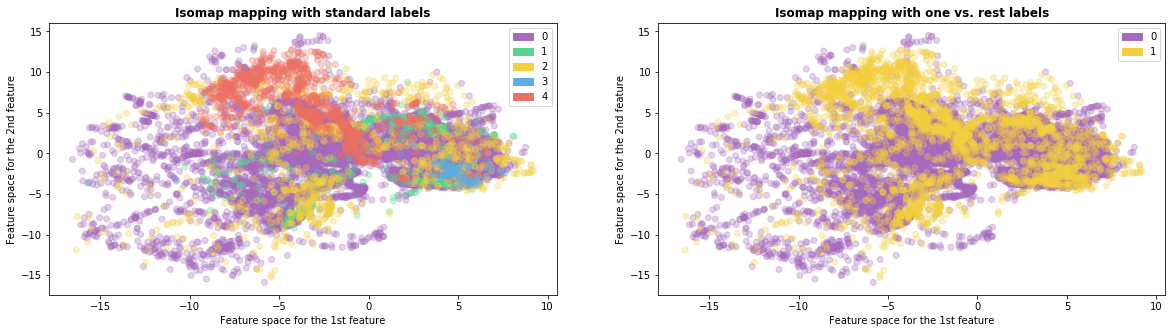

In [14]:
isomap = Isomap(n_neighbors = 5, n_components = 2, n_jobs = -1)
df_train_transformed = isomap.fit_transform(df_train_m)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_m.map({i:colors[i] for i in range(5)}), 
            alpha = 0.3)
plt.title("Isomap mapping with standard labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles)
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_ovr_m.map({i:colors2[i] for i in range(2)}), 
            alpha = 0.3)
plt.title("Isomap mapping with one vs. rest labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles2)
plt.show()

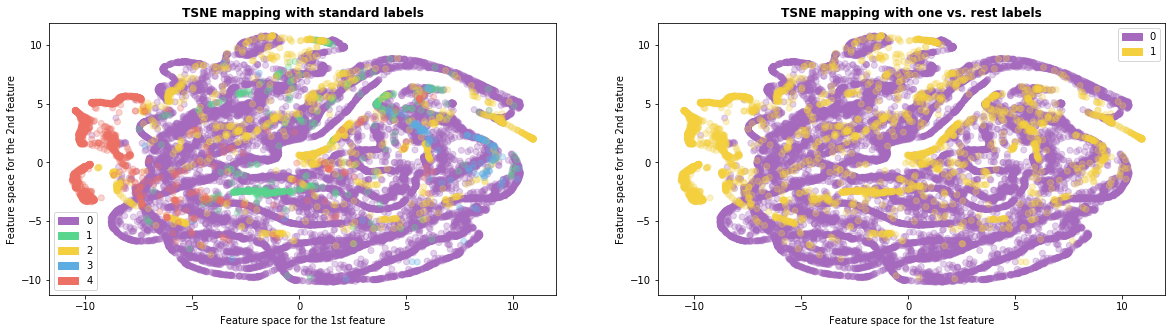

In [15]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 0, n_iter = 300)
df_train_transformed = tsne.fit_transform(df_train_m)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_m.map({i:colors[i] for i in range(5)}), 
            alpha = 0.3)
plt.title("TSNE mapping with standard labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles)
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_ovr_m.map({i:colors2[i] for i in range(2)}), 
            alpha = 0.3)
plt.title("TSNE mapping with one vs. rest labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles2)
plt.show()

# Clustering

We can start this approach seeing which is the best optimal number of clusters to do, this can be done by the objective method of the elbow curve

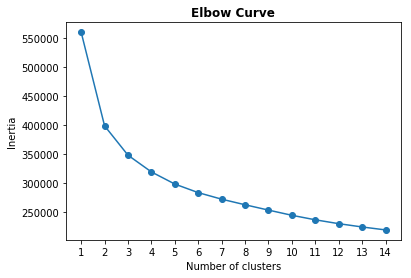

In [18]:
nclust = range(1,15)
inertias = []
for k in nclust:
    model = KMeans(n_clusters = k, n_jobs = -1, random_state = 1)
    model.fit(df_train)
    inertias.append(model.inertia_)

plt.plot(nclust, inertias, "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Curve", weight = "bold")
plt.xticks(nclust)
plt.show()

so we can see that 2 is a not so bad approach, representing the one vs. all labels, but 5 seems to be the best approach, representing the actual labels.

## One vs. rest

So, doing first the approach with 2 clusters we can check the performance of the model looking at its silhouette plot

In [19]:
def make_silhouette_plot(X, cluster_labels, n_clusters):
    # Make the necessary space
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])

    # Compute silhouette scores for each sample and average
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        if n_clusters == 2:
            color = colors2
        else:
            color = colors
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor = color[i], edgecolor = color[i], alpha = 0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

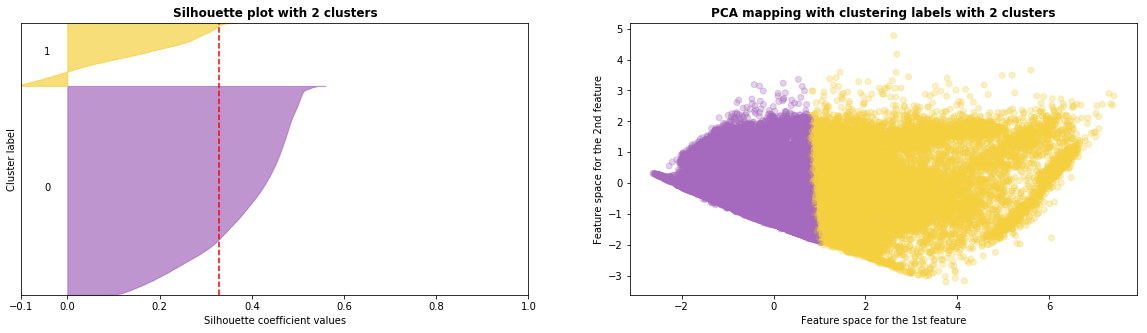

In [20]:
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
cluster_labels = kmeans.fit_predict(df_train)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
make_silhouette_plot(df_train, cluster_labels, n_clusters)
plt.title("Silhouette plot with {} clusters".format(n_clusters), weight = "bold")
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = pd.Series(cluster_labels).map({i:colors2[i] for i in range(2)}), 
            alpha = 0.3)
plt.title("PCA mapping with clustering labels with {} clusters".format(n_clusters), weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

## Real labels

We can repeat this with the 5 clusters aproach

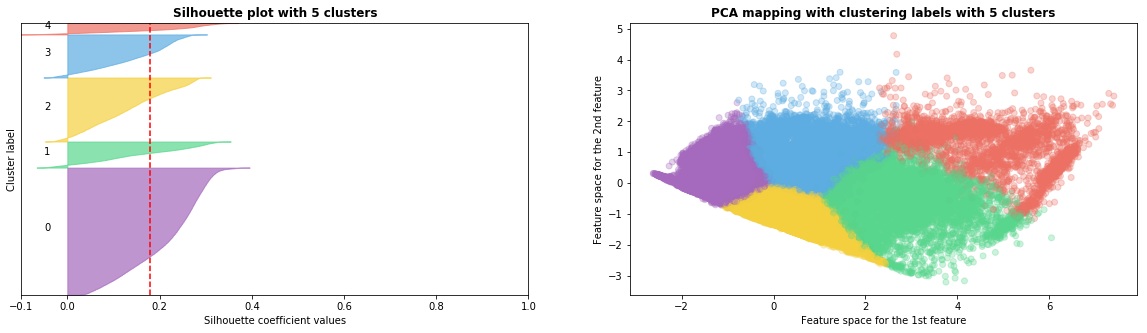

In [21]:
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
cluster_labels = kmeans.fit_predict(df_train)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
make_silhouette_plot(df_train, cluster_labels, n_clusters)
plt.title("Silhouette plot with {} clusters".format(n_clusters), weight = "bold")
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = pd.Series(cluster_labels).map({i:colors[i] for i in range(5)}),
            alpha = 0.3)
plt.title("PCA mapping with clustering labels with {} clusters".format(n_clusters), weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

## Aglomerative Clustering

In [36]:
df = stratified_sample(mitbih_train, "label", 0.2)
df_train_m = df.drop(["label", "label_ovr"], axis = 1)
df_label_m = df["label"]
df_label_ovr_m = df["label_ovr"]

In [53]:
df_train_transformed_str = pca.fit_transform(df)

In [45]:
%%time 
n_clusters=5
cluster_AC=AgglomerativeClustering(n_clusters=n_clusters).fit( np.array(df_train_m) )

clusterAC_labels=cluster_AC.labels_

CPU times: user 31.7 s, sys: 1.15 s, total: 32.9 s
Wall time: 1min 2s


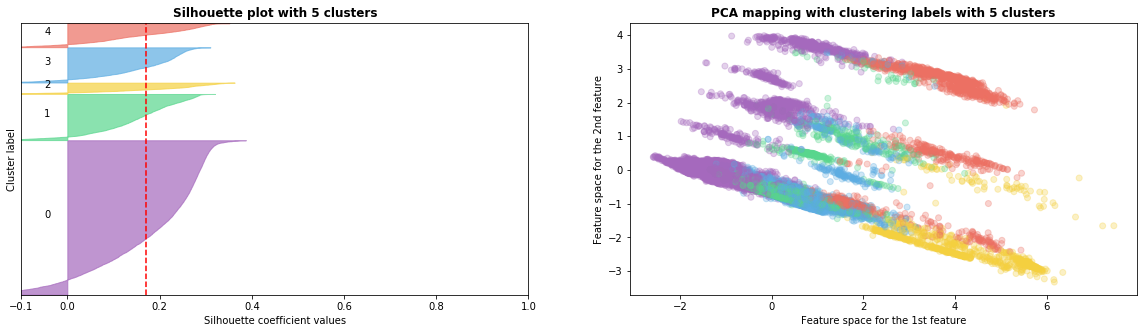

In [54]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
make_silhouette_plot(df_train_m, clusterAC_labels, n_clusters)
plt.title("Silhouette plot with {} clusters".format(n_clusters), weight = "bold")
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed_str[:,0], 
            y = df_train_transformed_str[:,1], 
            c = pd.Series(clusterAC_labels).map({i:colors[i] for i in range(5)}),
            alpha = 0.3)
plt.title("PCA mapping with clustering labels with {} clusters".format(n_clusters), weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

# Supervised: standard algorithms

Now we are going to try some standard classfication algorithms to have a benchmark to the complicated models that we are going to use in the next sections.

In [10]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_train, df_label_ovr,
                                                    test_size = 0.3, stratify = df_label, 
                                                    random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(df_train, df_label,
                                                    test_size = 0.3, stratify = df_label, 
                                                    random_state = 0)

In [11]:
def make_classifier(classifier, label, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_pred, y_test)
    cm = cm.astype('float') / cm.sum(axis=0)
    
    print("Accuracy train:", classifier.score(X_train, y_train))
    print("Accuracy test: ", classifier.score(X_test, y_test))
    
    if len(np.unique(y_train)) == 2:
        color = colors2
    else:
        color = colors
    
    plt.figure(figsize = (10,5))
    sns.heatmap(cm, annot = True, fmt = '.4f', cmap = plt.cm.Blues)
    plt.title("Confusion matrix for {}".format(label), weight = "bold")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()
    
    plt.figure(figsize = (10,5))
    sns.countplot(x = "label", data = pd.DataFrame(y_pred, columns = ["label"]), palette = color)
    plt.title("Distribution of predicted classes for {}".format(label), weight = "bold")
    plt.ylabel("Counts")
    plt.xlabel("Class")
    plt.show()
    
    print(classification_report(y_pred, y_test))

## Logistic Regression

Accuracy train: 0.9056896242269976
Accuracy test:  0.9045951193512772


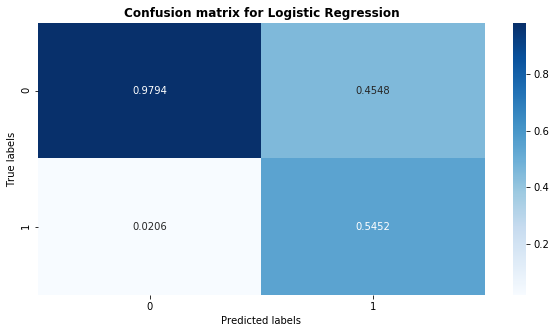

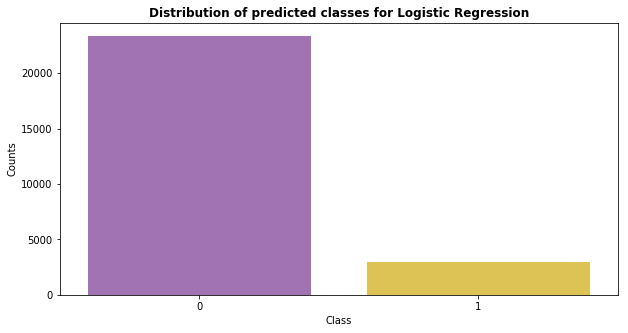

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     23352
           1       0.55      0.85      0.66      2915

   micro avg       0.90      0.90      0.90     26267
   macro avg       0.76      0.88      0.80     26267
weighted avg       0.93      0.90      0.91     26267

Accuracy train: 0.9141742947117659
Accuracy test:  0.9123995888377051


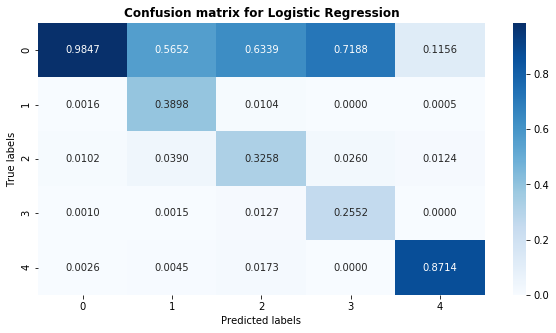

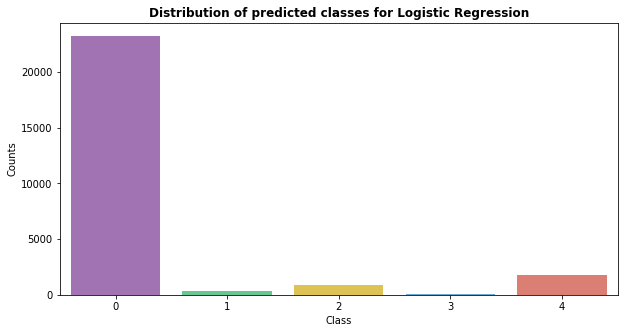

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     23249
           1       0.39      0.83      0.53       313
           2       0.33      0.67      0.44       842
           3       0.26      0.53      0.34        93
           4       0.87      0.95      0.91      1770

   micro avg       0.91      0.91      0.91     26267
   macro avg       0.57      0.78      0.63     26267
weighted avg       0.95      0.91      0.93     26267



In [12]:
classifier = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", n_jobs = -1)
make_classifier(classifier, "Logistic Regression" , X_train2, X_test2, y_train2, y_test2)
make_classifier(classifier, "Logistic Regression" , X_train, X_test, y_train, y_test)

## Decision Tree

Accuracy train: 1.0
Accuracy test:  0.9585792058476416


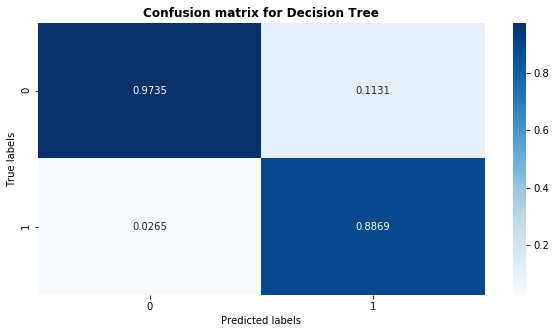

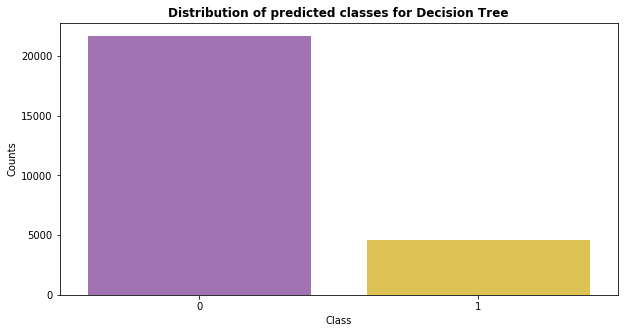

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     21678
           1       0.89      0.87      0.88      4589

   micro avg       0.96      0.96      0.96     26267
   macro avg       0.93      0.93      0.93     26267
weighted avg       0.96      0.96      0.96     26267

Accuracy train: 1.0
Accuracy test:  0.9586553470133627


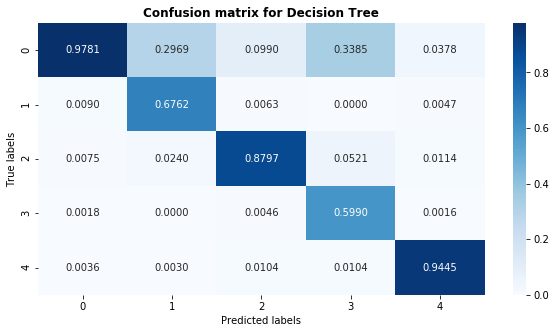

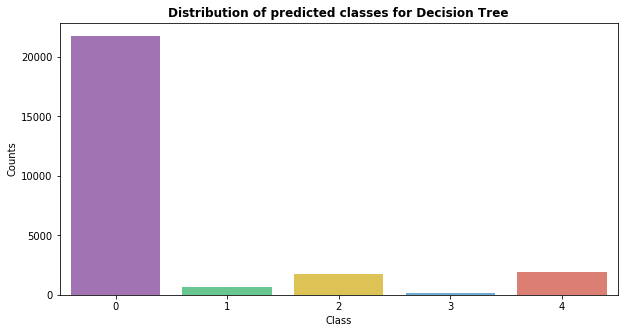

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     21773
           1       0.68      0.68      0.68       667
           2       0.88      0.88      0.88      1739
           3       0.60      0.69      0.64       166
           4       0.94      0.95      0.95      1922

   micro avg       0.96      0.96      0.96     26267
   macro avg       0.82      0.83      0.82     26267
weighted avg       0.96      0.96      0.96     26267



In [25]:
classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
make_classifier(classifier, "Decision Tree" , X_train2, X_test2, y_train2, y_test2)
make_classifier(classifier, "Decision Tree" , X_train, X_test, y_train, y_test)

# Supervised: ensembles

## Random forest

Accuracy train: 0.9999347333039633
Accuracy test:  0.9762439562949708


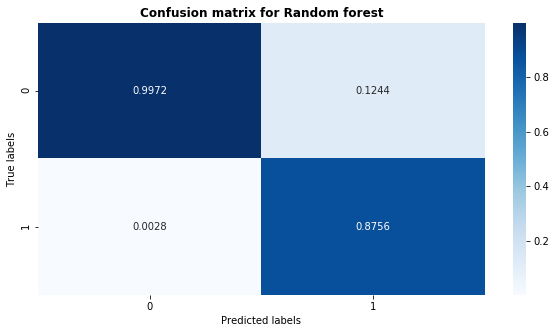

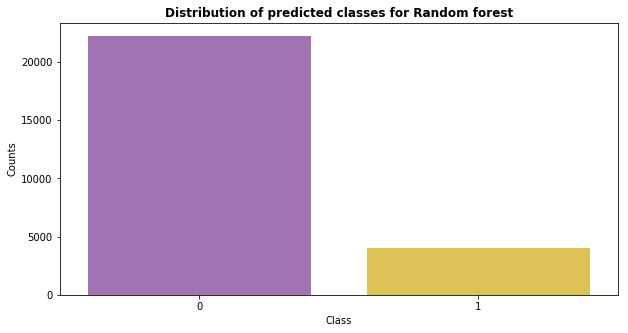

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     22244
           1       0.88      0.98      0.93      4023

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.94      0.98      0.96     26267
weighted avg       0.98      0.98      0.98     26267

Accuracy train: 0.9999673666519817
Accuracy test:  0.9742642859862185


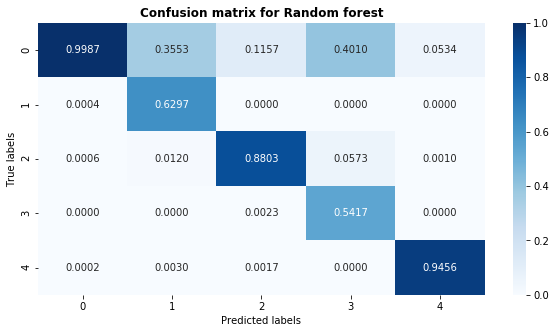

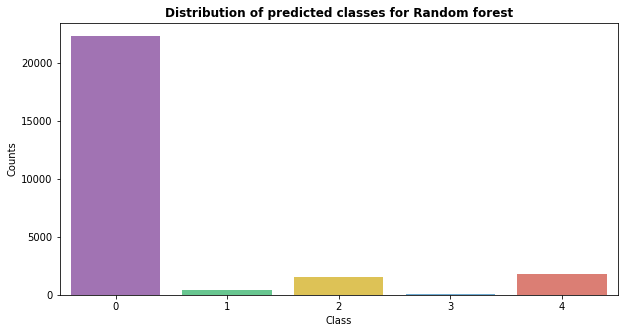

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     22332
           1       0.63      0.98      0.77       429
           2       0.88      0.98      0.93      1564
           3       0.54      0.95      0.69       109
           4       0.95      1.00      0.97      1833

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.80      0.98      0.87     26267
weighted avg       0.98      0.97      0.98     26267



In [26]:
classifier = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state = 0)
make_classifier(classifier, "Random Forest" , X_train2, X_test2, y_train2, y_test2)
make_classifier(classifier, "Random Forest" , X_train, X_test, y_train, y_test)

## Extremely Randomized Trees

Accuracy train: 1.0
Accuracy test:  0.9774241443636502


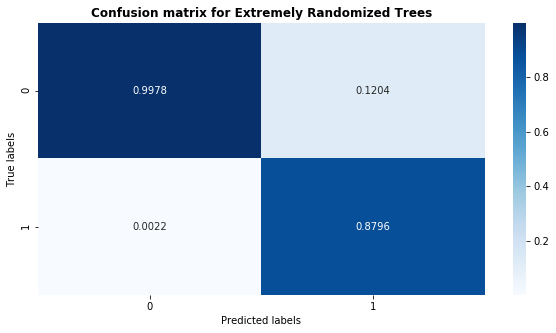

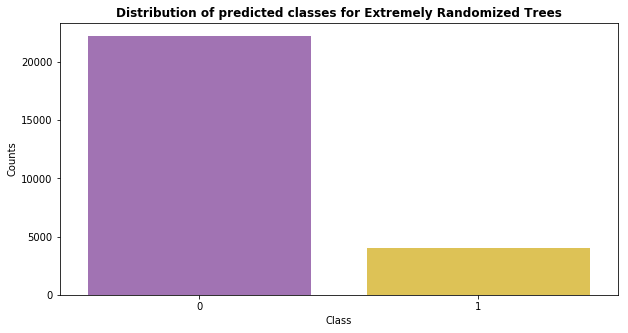

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22239
           1       0.88      0.99      0.93      4028

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.94      0.98      0.96     26267
weighted avg       0.98      0.98      0.98     26267

Accuracy train: 1.0
Accuracy test:  0.9748353447291278


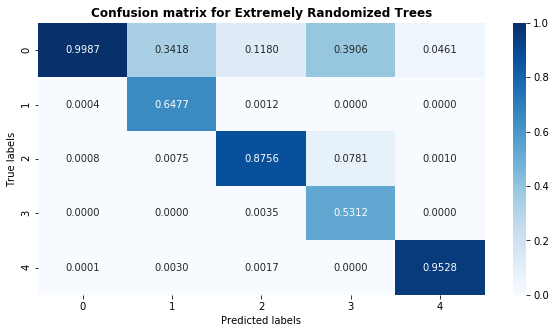

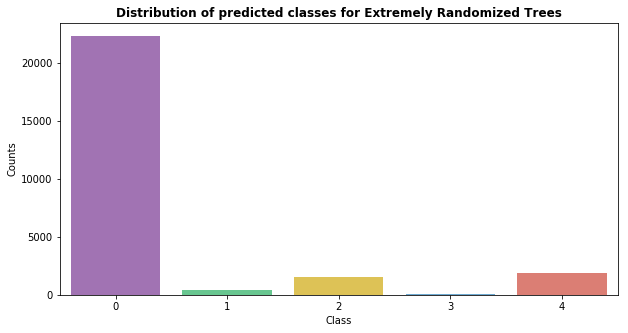

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     22310
           1       0.65      0.98      0.78       443
           2       0.88      0.97      0.92      1560
           3       0.53      0.94      0.68       109
           4       0.95      1.00      0.97      1845

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.80      0.97      0.87     26267
weighted avg       0.98      0.97      0.98     26267



In [28]:
classifier = ExtraTreesClassifier(n_estimators = 50, n_jobs = -1, random_state = 0)
make_classifier(classifier, "Extremely Randomized Trees" , X_train2, X_test2, y_train2, y_test2)
make_classifier(classifier, "Extremely Randomized Trees" , X_train, X_test, y_train, y_test)

## Unbalanced Learning

In [30]:
def undersampling(X_train, y_train):
    # Get the indexes of the majoritarian class
    idx = y_train[y_train == 0].index.tolist()
    # Sample over them
    idx = random.sample(idx, 20000)
    # Keep the rest
    X_train = X_train.drop(idx, axis = 0)
    y_train = y_train.drop(idx, axis = 0)
    
    return X_train, y_train

In [36]:
X_train_under, y_train_under = undersampling(X_train, y_train)
X_train2_under, y_train2_under = undersampling(X_train2, y_train2)

sampler = RandomOverSampler(ratio={0:50729,1:5000,2:5000,3:5000,4:5000})
X_train_over, y_train_over = sampler.fit_sample(X_train, y_train)

sampler = RandomOverSampler(ratio={0:50729,1:20000})
X_train2_over, y_train2_over = sampler.fit_sample(X_train2, y_train2)

Accuracy train: 0.9999515586019813
Accuracy test:  0.9770434385350439


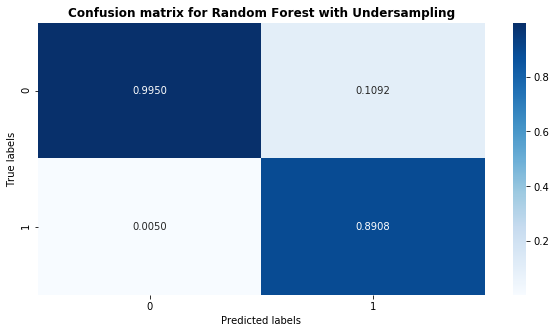

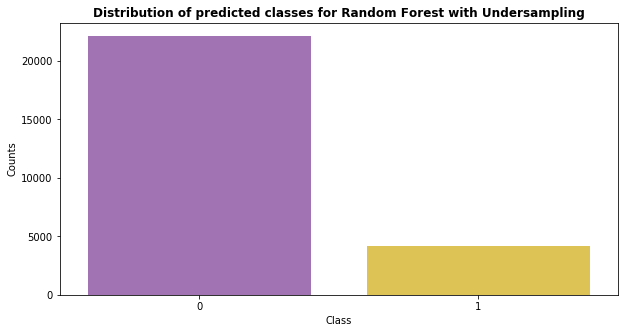

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     22127
           1       0.89      0.97      0.93      4140

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.94      0.98      0.96     26267
weighted avg       0.98      0.98      0.98     26267

Accuracy train: 0.9999273379029718
Accuracy test:  0.9752541211405946


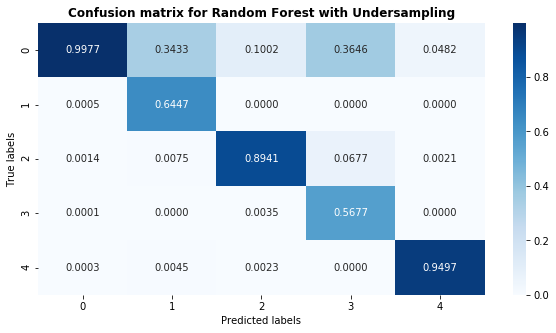

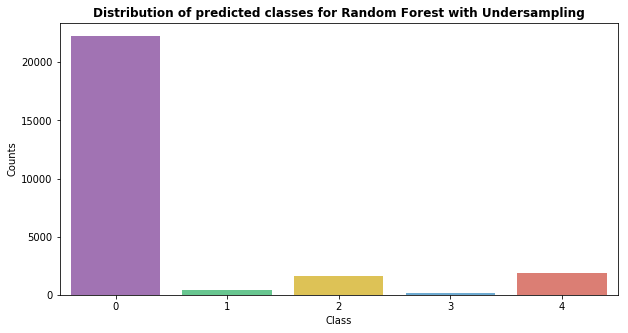

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     22259
           1       0.64      0.98      0.78       441
           2       0.89      0.97      0.93      1605
           3       0.57      0.93      0.71       117
           4       0.95      0.99      0.97      1845

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.81      0.97      0.87     26267
weighted avg       0.98      0.98      0.98     26267



In [37]:
classifier = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state = 0)
make_classifier(classifier, "Random Forest with Undersampling" , X_train2_under, X_test2, y_train2_under, y_test2)
make_classifier(classifier, "Random Forest with Undersampling" , X_train_under, X_test, y_train_under, y_test)

Accuracy train: 0.9999575845834099
Accuracy test:  0.9779190619408383


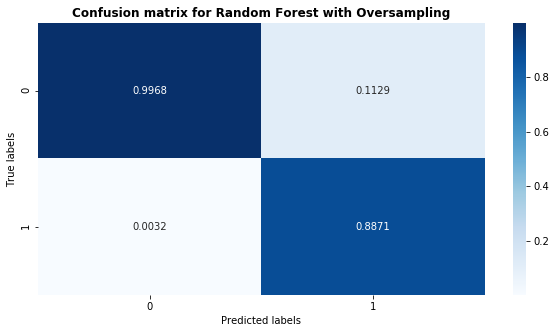

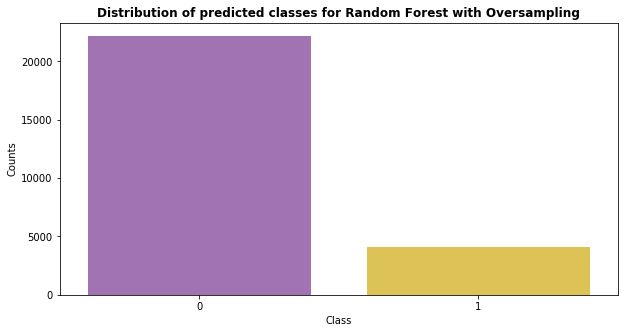

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22184
           1       0.89      0.98      0.93      4083

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.94      0.98      0.96     26267
weighted avg       0.98      0.98      0.98     26267

Accuracy train: 0.9999858615278033
Accuracy test:  0.9744546389005215


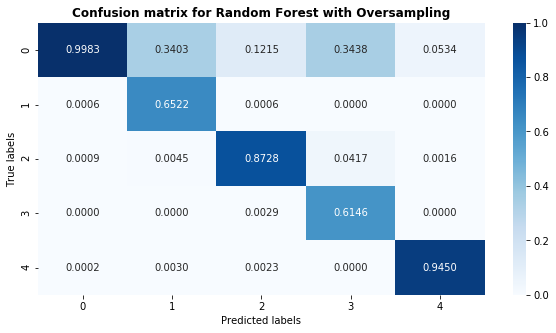

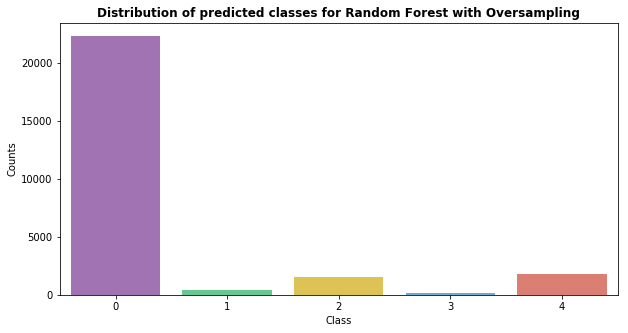

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     22311
           1       0.65      0.97      0.78       449
           2       0.87      0.98      0.92      1550
           3       0.61      0.95      0.75       124
           4       0.95      0.99      0.97      1833

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.82      0.97      0.88     26267
weighted avg       0.98      0.97      0.98     26267



In [38]:
classifier = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state = 0)
make_classifier(classifier, "Random Forest with Oversampling" , X_train2_over, X_test2, y_train2_over, y_test2)
make_classifier(classifier, "Random Forest with Oversampling" , X_train_over, X_test, y_train_over, y_test)

Accuracy train: 1.0
Accuracy test:  0.9789850382609357


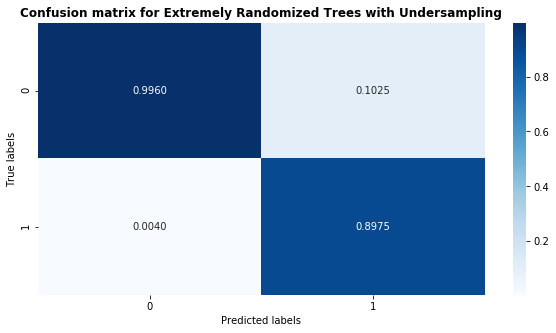

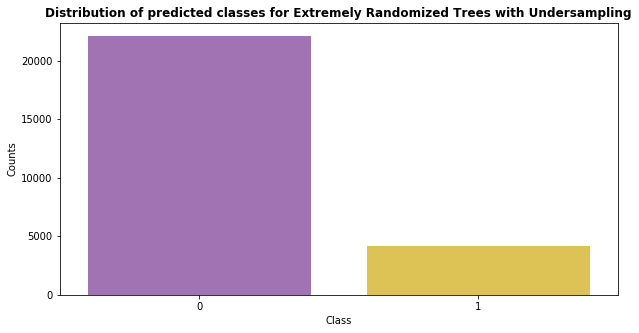

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22118
           1       0.90      0.98      0.94      4149

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.95      0.98      0.96     26267
weighted avg       0.98      0.98      0.98     26267

Accuracy train: 1.0
Accuracy test:  0.9761678151292497


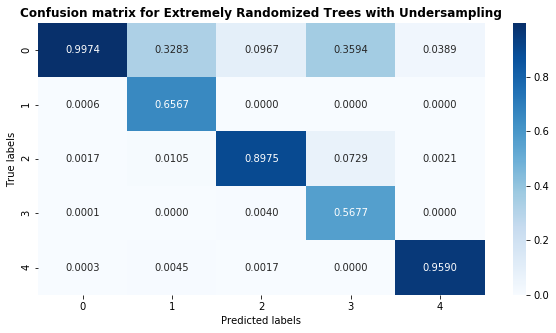

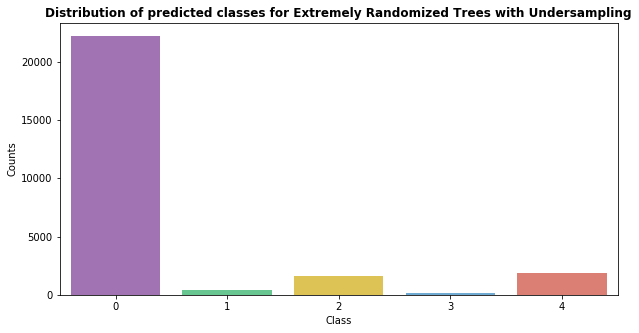

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22216
           1       0.66      0.97      0.78       450
           2       0.90      0.96      0.93      1621
           3       0.57      0.92      0.70       118
           4       0.96      0.99      0.98      1862

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.82      0.97      0.88     26267
weighted avg       0.98      0.98      0.98     26267



In [39]:
classifier = ExtraTreesClassifier(n_estimators = 50, n_jobs = -1, random_state = 0)
make_classifier(classifier, "Extremely Randomized Trees with Undersampling" , X_train2_under, X_test2, y_train2_under, y_test2)
make_classifier(classifier, "Extremely Randomized Trees with Undersampling" , X_train_under, X_test, y_train_under, y_test)

Accuracy train: 1.0
Accuracy test:  0.9773480031979289


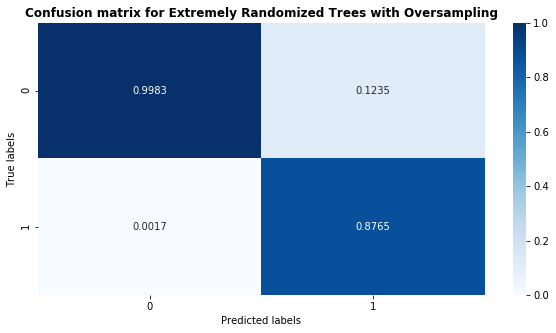

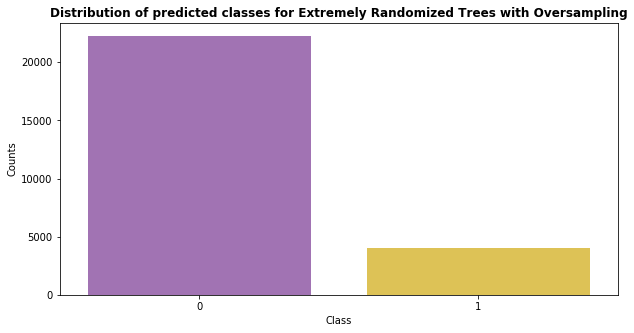

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     22265
           1       0.88      0.99      0.93      4002

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.94      0.98      0.96     26267
weighted avg       0.98      0.98      0.98     26267

Accuracy train: 1.0
Accuracy test:  0.974606921231964


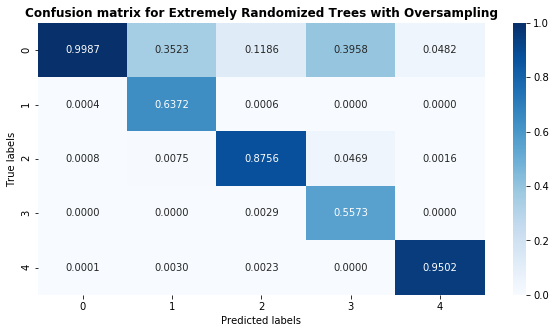

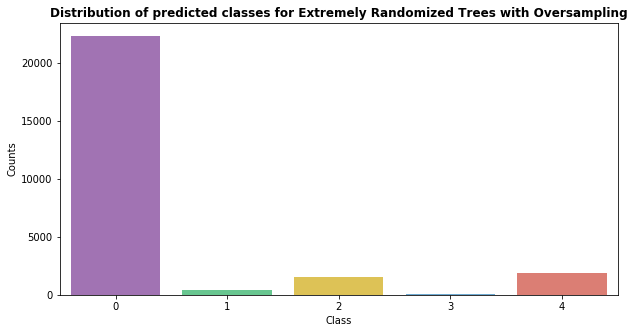

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     22324
           1       0.64      0.98      0.77       435
           2       0.88      0.98      0.92      1555
           3       0.56      0.96      0.70       112
           4       0.95      1.00      0.97      1841

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.80      0.98      0.87     26267
weighted avg       0.98      0.97      0.98     26267



In [40]:
classifier = ExtraTreesClassifier(n_estimators = 50, n_jobs = -1, random_state = 0)
make_classifier(classifier, "Extremely Randomized Trees with Oversampling" , X_train2_over, X_test2, y_train2_over, y_test2)
make_classifier(classifier, "Extremely Randomized Trees with Oversampling" , X_train_over, X_test, y_train_over, y_test)

# Supervised: deep learning

## Dense model

In [16]:
model = Sequential()
model.add(Dense(50, activation = "relu", input_shape = (187,)))
model.add(Dense(50, activation = "relu"))
model.add(Dense(5,  activation = "softmax"))
model.summary()

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
model.fit(X_train, to_categorical(y_train), epochs=100)

mse, acc = model.evaluate(X_test, to_categorical(y_test))
print("Evaluation: ")
print("MSE :", mse)
print("Accuracy: ", acc)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                9400      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
Total params: 12,205
Trainable params: 12,205
Non-trainable params: 0
_________________________________________________________________


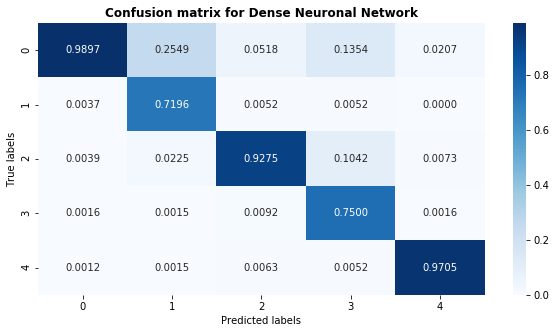

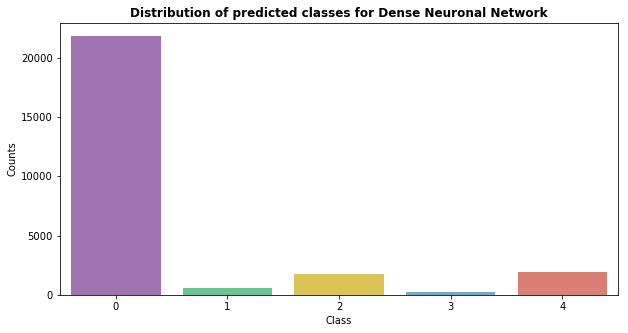

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21843
           1       0.72      0.84      0.78       570
           2       0.93      0.92      0.93      1744
           3       0.75      0.72      0.74       199
           4       0.97      0.98      0.98      1911

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.87      0.89      0.88     26267
weighted avg       0.98      0.98      0.98     26267



In [18]:
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_pred, y_test)
cm = cm.astype('float') / cm.sum(axis=0)

color = colors
label = "Dense Neuronal Network"
    
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = '.4f', cmap = plt.cm.Blues)
plt.title("Confusion matrix for {}".format(label), weight = "bold")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
    
plt.figure(figsize = (10,5))
sns.countplot(x = "label", data = pd.DataFrame(y_pred, columns = ["label"]), palette = color)
plt.title("Distribution of predicted classes for {}".format(label), weight = "bold")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

print(classification_report(y_pred, y_test))

In [19]:
model = Sequential()
model.add(Dense(50, activation = "relu", input_shape = (187,)))
model.add(Dense(50, activation = "relu"))
model.add(Dense(2,  activation = "softmax"))
model.summary()

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
model.fit(X_train2, to_categorical(y_train2), epochs=100)

mse, acc = model.evaluate(X_test2, to_categorical(y_test2))
print("Evaluation: ")
print("MSE :", mse)
print("Accuracy: ", acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                9400      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
Total params: 12,052
Trainable params: 12,052
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
61287/61287 [==============================] - 3s 53us/step - loss: 0.2122 - acc: 0.9266
Epoch 2/100
61287/61287 [==============================] - 3s 47us/step - loss: 0.1370 - acc: 0.9565
Epoch 3/100
61287/61287 [==============================] - 3s 55us/step - loss: 0.1141 - acc: 0.9635
Epoch 4/100
61287/61287 [==============================] - 3s 48us/step - loss: 0.1003 - acc: 0.968

61287/61287 [==============================] - 3s 48us/step - loss: 0.0213 - acc: 0.9923
Epoch 74/100
61287/61287 [==============================] - ETA: 0s - loss: 0.0205 - acc: 0.992 - 3s 47us/step - loss: 0.0204 - acc: 0.9929
Epoch 75/100
61287/61287 [==============================] - 3s 45us/step - loss: 0.0202 - acc: 0.9930
Epoch 76/100
61287/61287 [==============================] - 3s 46us/step - loss: 0.0199 - acc: 0.9933: 1s - loss: - ETA: 0s - loss: 0.0201 - acc
Epoch 77/100
61287/61287 [==============================] - 3s 44us/step - loss: 0.0192 - acc: 0.9933
Epoch 78/100
61287/61287 [==============================] - 3s 42us/step - loss: 0.0201 - acc: 0.9927: 0s - loss: 0.0196 - 
Epoch 79/100
61287/61287 [==============================] - 3s 42us/step - loss: 0.0198 - acc: 0.9934
Epoch 80/100
61287/61287 [==============================] - 3s 42us/step - loss: 0.0192 - acc: 0.9934
Epoch 81/100
61287/61287 [==============================] - 3s 42us/step - loss: 0.0195 - acc:

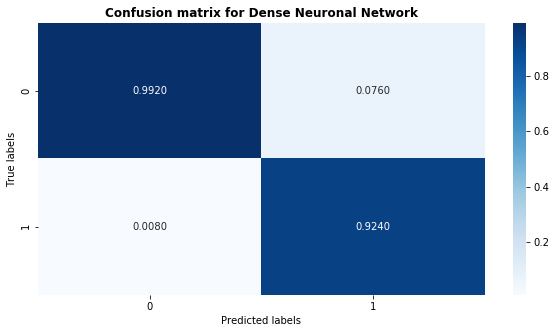

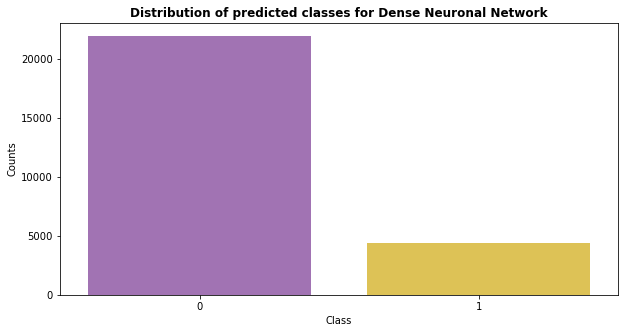

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     21913
           1       0.92      0.96      0.94      4354

   micro avg       0.98      0.98      0.98     26267
   macro avg       0.96      0.97      0.96     26267
weighted avg       0.98      0.98      0.98     26267



In [20]:
y_pred2 = model.predict_classes(X_test2)
cm = confusion_matrix(y_pred2, y_test2)
cm = cm.astype('float') / cm.sum(axis=0)

color = colors2
label = "Dense Neuronal Network"
    
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = '.4f', cmap = plt.cm.Blues)
plt.title("Confusion matrix for {}".format(label), weight = "bold")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
    
plt.figure(figsize = (10,5))
sns.countplot(x = "label", data = pd.DataFrame(y_pred2, columns = ["label"]), palette = color)
plt.title("Distribution of predicted classes for {}".format(label), weight = "bold")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

print(classification_report(y_pred2, y_test2))

## Convolutional

In [29]:
X_train_NN = np.resize( X_train,(X_train.shape[0],X_train.shape[1],1) )
X_test_NN = np.resize( X_test,(X_test.shape[0],X_test.shape[1],1) )

n_obs = X_train.shape[0]
batch_size = 500
filt_value = 32

inp = Input(shape=(187, 1))
C = Conv1D(filters=filt_value, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(C)
C11 = BatchNormalization()(C11)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(D11)
C12 = BatchNormalization()(C12)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(D12)

C21 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(M11)
C21 = BatchNormalization()(C21)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(D21)
C22 = BatchNormalization()(C22)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(D22)

C31 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(M21)
C31 = BatchNormalization()(C31)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(A31)
C32 = BatchNormalization()(C32)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

C41 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(M31)
C41 = BatchNormalization()(C41)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(A41)
C42 = BatchNormalization()(C42)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

C51 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(M41)
C51 = BatchNormalization()(C51)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(A51)
C52 = BatchNormalization()(C52)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(filt_value)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(filt_value)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
model.fit(X_train_NN, to_categorical(y_train), epochs=100)

mse, acc = model.evaluate(X_test_NN, to_categorical(y_test))
print("Evaluation: ")
print("MSE :", mse)
print("Accuracy: ", acc)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 183, 32)      192         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 183, 32)      5152        conv1d_34[0][0]                  
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 183, 32)      128         conv1d_35[0][0]                  
__________________________________________________________________________________________________
activation

Epoch 1/100
61287/61287 [==============================] - 120s 2ms/step - loss: 0.2855 - acc: 0.9231
Epoch 2/100
61287/61287 [==============================] - 104s 2ms/step - loss: 0.1522 - acc: 0.9574
Epoch 3/100
61287/61287 [==============================] - 104s 2ms/step - loss: 0.1248 - acc: 0.9654
Epoch 4/100
61287/61287 [==============================] - 105s 2ms/step - loss: 0.1097 - acc: 0.9693
Epoch 5/100
61287/61287 [==============================] - 106s 2ms/step - loss: 0.0975 - acc: 0.9721
Epoch 6/100
61287/61287 [==============================] - 108s 2ms/step - loss: 0.0877 - acc: 0.9744
Epoch 7/100
61287/61287 [==============================] - 108s 2ms/step - loss: 0.0819 - acc: 0.9765
Epoch 8/100
61287/61287 [==============================] - 104s 2ms/step - loss: 0.0759 - acc: 0.9780
Epoch 9/100
61287/61287 [==============================] - 104s 2ms/step - loss: 0.0704 - acc: 0.9797
Epoch 10/100
61287/61287 [==============================] - 106s 2ms/step - loss: 

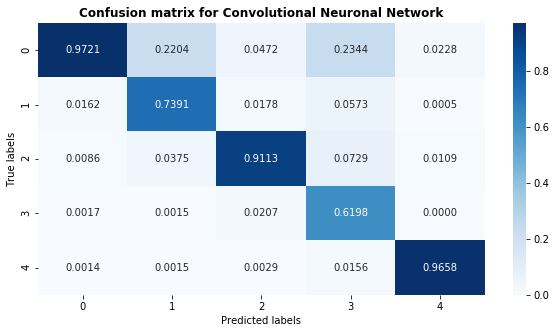

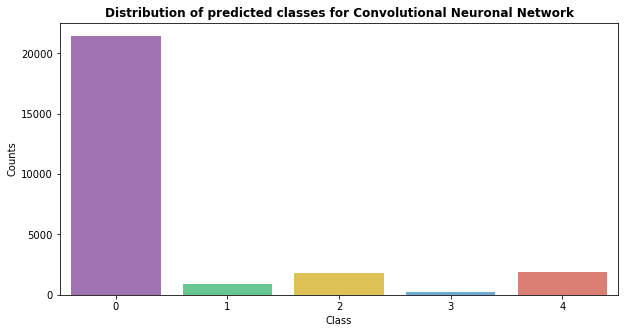

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     21453
           1       0.74      0.56      0.63       888
           2       0.91      0.87      0.89      1830
           3       0.62      0.61      0.62       194
           4       0.97      0.98      0.97      1902

   micro avg       0.96      0.96      0.96     26267
   macro avg       0.84      0.80      0.82     26267
weighted avg       0.96      0.96      0.96     26267



In [34]:
y_pred = model.predict(X_test_NN,batch_size=1000).argmax(axis=1)

cm = confusion_matrix(y_pred, y_test)
cm = cm.astype('float') / cm.sum(axis=0)

color = colors
label = "Convolutional Neuronal Network"
    
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = '.4f', cmap = plt.cm.Blues)
plt.title("Confusion matrix for {}".format(label), weight = "bold")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
    
plt.figure(figsize = (10,5))
sns.countplot(x = "label", data = pd.DataFrame(y_pred, columns = ["label"]), palette = color)
plt.title("Distribution of predicted classes for {}".format(label), weight = "bold")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

print(classification_report(y_pred, y_test))

In [ ]:
X_train_NN = np.resize( X_train2,(X_train2.shape[0],X_train2.shape[1],1) )
X_test_NN = np.resize( X_test2,(X_test2.shape[0],X_test2.shape[1],1) )

n_obs = X_train2.shape[0]
batch_size = 500
filt_value = 32

inp = Input(shape=(187, 1))
C = Conv1D(filters=filt_value, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(C)
C11 = BatchNormalization()(C11)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(D11)
C12 = BatchNormalization()(C12)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(D12)

C21 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(M11)
C21 = BatchNormalization()(C21)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(D21)
C22 = BatchNormalization()(C22)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(D22)

C31 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(M21)
C31 = BatchNormalization()(C31)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(A31)
C32 = BatchNormalization()(C32)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

C41 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(M31)
C41 = BatchNormalization()(C41)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(A41)
C42 = BatchNormalization()(C42)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

C51 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(M41)
C51 = BatchNormalization()(C51)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=filt_value, kernel_size=5, strides=1, padding='same')(A51)
C52 = BatchNormalization()(C52)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(filt_value)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(filt_value)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
model.fit(X_train_NN, to_categorical(y_train2), epochs=100)

mse, acc = model.evaluate(X_test_NN, to_categorical(y_test2))
print("Evaluation: ")
print("MSE :", mse)
print("Accuracy: ", acc)

In [ ]:
y_pred = model.predict(X_test_NN,batch_size=1000).argmax(axis=1)

cm = confusion_matrix(y_pred, y_test2)
cm = cm.astype('float') / cm.sum(axis=0)

color = colors
label = "Convolutional Neuronal Network"
    
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = '.4f', cmap = plt.cm.Blues)
plt.title("Confusion matrix for {}".format(label), weight = "bold")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
    
plt.figure(figsize = (10,5))
sns.countplot(x = "label", data = pd.DataFrame(y_pred, columns = ["label"]), palette = color)
plt.title("Distribution of predicted classes for {}".format(label), weight = "bold")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

print(classification_report(y_pred, y_test2))

# Resources

https://www.kaggle.com/shayanfazeli/heartbeat

https://scikit-learn.org/stable/

https://imbalanced-learn.readthedocs.io/en/stable/api.html  

https://keras.io/